In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import altair as alt
import pickle
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import altair as alt
alt.renderers.enable('notebook')

import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from pandas.io.json import json_normalize
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.naive_bayes import MultinomialNB


from imblearn.under_sampling import CondensedNearestNeighbour, RandomUnderSampler, EditedNearestNeighbours, RepeatedEditedNearestNeighbours
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE, SVMSMOTE
from imblearn.combine import SMOTETomek, SMOTEENN



In [117]:
df = pd.read_csv('../data/processed/final_book_df.csv', index_col=0)

In [118]:
df2 = pd.read_csv('../data/processed/reddit_df_with_dates.csv', index_col=0)

In [119]:
df2.head(2)

,text,info,duck_dates,ask_dates,date
0,"Really, the whole paragraph is good, but in pa...",A Farewell to Arms,['1929'],['1929'],1929
1,"""I looked at the stars, and considered how awf...","Dickens, Great Expectations",[],"['1860', '1861']",1860


In [120]:
df2 = df2.drop(columns=['duck_dates', 'ask_dates'])
df = df.append(df2)

In [121]:
df = df.reset_index()
df = df.drop(columns=['index'])

In [122]:
df.shape

(1158, 4)

In [123]:
df.describe()

,date,target
count,1158.000000,1022.000000
mean,1855.466321,2.529354
std,125.959715,1.738716
min,1511.000000,0.000000
25%,1800.000000,1.000000
50%,1898.000000,2.000000
75%,1939.000000,4.000000
max,2016.000000,5.000000


In [124]:
df = df.drop_duplicates(subset=['text'], keep='first', inplace=False)

In [125]:
df['date'] = df['date'].astype(int)

In [126]:
df.shape

(1097, 4)

In [127]:
df.isna().sum()

date        0
info        2
target    136
text        0
dtype: int64

# Clean Text

In [ ]:
from sklearn.base import TransformerMixin

class LanguageTransformer(TransformerMixin):

    def fit(self, x_train):
        return self

    def transform(self, x_train):
        new_list = []
        new_line = []
        final_line = []
        final_entry = []
        for item in x_train:
            new_list.append(item + ', ')
            for list_item in new_list:
                new_line.append(list_item.split())
                for line in new_line:
                    final_line = []
                    for word in line:
                        lemmatizer = WordNetLemmatizer()
                        raw_text = str(word)
                        string_lower_case = raw_text.lower()
                        # new_text = string_lower_case.astype('U')
                        retokenizer = RegexpTokenizer(r'[a-z]+')
                        words = retokenizer.tokenize(string_lower_case)
                        lemm_words = lemmatizer.lemmatize(" ".join(words))
                        final_line.append(lemm_words)

                final_entry.append(final_line)


        return final_entry

In [ ]:
ct = LanguageTransformer()
ct.fit_transform(df['text'])

# Function to Grid Search Target Dates

In [14]:
## Two preliminary instantiated vectorizers to be used in GridSearch function

cvec = CountVectorizer(stop_words='english',
                        lowercase=True,
                        ngram_range=(1, 3),
                        strip_accents='unicode')

tvec = TfidfVectorizer(stop_words='english',
                        ngram_range=(1, 3),
                        encoding='utf-8')

In [15]:
bin_list = [
    [0, 1670, 1800, 1870, 1910, 1945, np.inf],
    [0, 1670, 1830, 1870, 1910, 1945, np.inf],
    [0, 1670, 1830, 1870, 1920, 1945, np.inf],
    [0, 1670, 1800, 1870, 1920, 1945, np.inf],
    [0, 1670, 1800, 1870, 1920, 1960, np.inf],
    [0, 1670, 1830, 1890, 1920, 1945, np.inf],
    [0, 1670, 1830, 1890, 1920, 1950, np.inf],
    [0, 1670, 1830, 1890, 1910, 1945, np.inf],
    [0, 1670, 1830, 1890, 1930, 1975, np.inf],
    [0, 1700, 1800, 1870, 1910, 1945, np.inf],
    [0, 1700, 1830, 1890, 1910, 1945, np.inf],
    [0, 1700, 1830, 1870, 1920, 1945, np.inf],
    [0, 1670, 1830, 1870, 1920, 1975, np.inf],
    [0, 1670, 1830, 1890, 1920, 1975, np.inf],
    [0, 1600, 1700, 1800, 1900, 1950, np.inf],
    [0, 1670, 1830, 1920, 1950, 1990, np.inf],
    [0, 1700, 1830, 1890, 1910, 1945, np.inf],
    [0, 1670, 1830, 1910, 1950, 1990, np.inf],
    [0, 1670, 1870, 1910, 1950, 1990, np.inf],
    [0, 1670, 1830, 1890, 1920, 1990, np.inf],
    [0, 1670, 1830, 1890, 1930, 1990, np.inf],
    [0, 1670, 1830, 1890, 1920, 1960, np.inf]
]

In [16]:
def make_targets(bin_list, model, vectorizer, df=df):
    
    '''
    Function to grid search and find the optimal target for time periods
    bin_list: several ways to classify the targets
    model: model to instantiate
    vectorizer: either cvec or tvec
    '''
    
    for b in bin_list:
        bins = b
        bin_names = range(0, 6)
        df['target'] = pd.cut(df['date'], bins, labels=bin_names)
        df.groupby('target').count()

        #train test split
        x = df['text']
        y = df['target']
        x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=.8, random_state=42, shuffle=True, stratify=y)
        
        #vectorizing
        train_data = vectorizer.fit_transform(x_train.apply(lambda x: np.str_(x)))
        test_data = vectorizer.transform(x_test.apply(lambda x: np.str_(x)))
        
        
        #instantiating, fitting, and scoring the model
        model = model
        model.fit(train_data, y_train)
        score = model.score(test_data, y_test)
        print(f' Accuracy of Bin {bins}: {score}')

In [17]:
make_targets(bin_list, model=LogisticRegression(class_weight='balanced'), vectorizer=cvec)

 Accuracy of Bin [0, 1670, 1800, 1870, 1910, 1945, inf]: 0.6772727272727272
 Accuracy of Bin [0, 1670, 1830, 1870, 1910, 1945, inf]: 0.6727272727272727
 Accuracy of Bin [0, 1670, 1830, 1870, 1920, 1945, inf]: 0.6636363636363637
 Accuracy of Bin [0, 1670, 1800, 1870, 1920, 1945, inf]: 0.6909090909090909
 Accuracy of Bin [0, 1670, 1800, 1870, 1920, 1960, inf]: 0.6909090909090909
 Accuracy of Bin [0, 1670, 1830, 1890, 1920, 1945, inf]: 0.7181818181818181
 Accuracy of Bin [0, 1670, 1830, 1890, 1920, 1950, inf]: 0.7090909090909091
 Accuracy of Bin [0, 1670, 1830, 1890, 1910, 1945, inf]: 0.6818181818181818
 Accuracy of Bin [0, 1670, 1830, 1890, 1930, 1975, inf]: 0.7454545454545455
 Accuracy of Bin [0, 1700, 1800, 1870, 1910, 1945, inf]: 0.6636363636363637
 Accuracy of Bin [0, 1700, 1830, 1890, 1910, 1945, inf]: 0.65
 Accuracy of Bin [0, 1700, 1830, 1870, 1920, 1945, inf]: 0.6454545454545455
 Accuracy of Bin [0, 1670, 1830, 1870, 1920, 1975, inf]: 0.6636363636363637
 Accuracy of Bin [0, 1670,

In [ ]:
make_targets(bin_list, model=RandomForestClassifier(), vectorizer=cvec) 

In [ ]:
make_targets(bin_list, model=RandomForestClassifier(), vectorizer=tvec)

In [ ]:
make_targets(bin_list, model=LogisticRegression(class_weight='balanced'), vectorizer=tvec)

# Binning & Cleaning

In [128]:
bins = [0, 1670, 1830, 1890, 1920, 1960, np.inf]
names = [0, 1, 2, 3, 4, 5]

df['target'] = pd.cut(df['date'], bins, labels=names)

df.groupby('target').count()

,date,info,text
target,,,
0,149,148,149
1,163,163,163
2,196,196,196
3,148,148,148
4,207,207,207
5,234,233,234


# EDA

In [129]:
df.shape

(1097, 4)

In [130]:
df.head(2)

,date,info,target,text
0,1528,The book of the Courtier,0,then the soul freed from vice purged by studie...
1,1569,Hamlet,0,his goodly frame the earth seems to me a steri...


In [131]:
df.isna().sum()

date      0
info      2
target    0
text      0
dtype: int64

In [132]:
df.dtypes

date         int64
info        object
target    category
text        object
dtype: object

In [133]:
df.target = df.target.astype(int)

In [50]:
# df.to_csv('../data/cleaned/book_df.csv')

# Countvectorizer Unigrams

In [25]:
stop = stopwords.words('english')
stop.extend(['one', 'word', 'us', 'could', 'go', 'let', 'see', 'would', 'two', 'said', 'made', 'brutus', 'dryden']) 

In [26]:
cvec = CountVectorizer(stop_words=stop)
unigrams = pd.DataFrame(cvec.fit_transform(df['text']).todense(), columns=cvec.get_feature_names())
unigrams['target'] = df['target']

In [27]:
target0_top_uni = unigrams.groupby('target').sum().T.sort_values(by=0, ascending=False)[[0]].head(20)
target1_top_uni = unigrams.groupby('target').sum().T.sort_values(by=1, ascending=False)[[0]].head(20)
target2_top_uni = unigrams.groupby('target').sum().T.sort_values(by=2, ascending=False)[[0]].head(20)
target3_top_uni = unigrams.groupby('target').sum().T.sort_values(by=3, ascending=False)[[0]].head(20)
target4_top_uni = unigrams.groupby('target').sum().T.sort_values(by=4, ascending=False)[[0]].head(20)
target5_top_uni = unigrams.groupby('target').sum().T.sort_values(by=5, ascending=False)[[0]].head(20)

In [28]:
def clean_gram_df(uni_df):
    unigram_df = uni_df.rename(columns={0: 'frequency'})
    unigram_df = unigram_df.reset_index()
    unigram_df = unigram_df.rename(columns={'index': 'word'})
    return unigram_df

In [29]:
# using the clean_uni_df function to create individual dataframes by target

target0 = clean_gram_df(target0_top_uni)
target1 = clean_gram_df(target1_top_uni)
target2 = clean_gram_df(target2_top_uni)
target3 = clean_gram_df(target3_top_uni)
target4 = clean_gram_df(target4_top_uni)
target5 = clean_gram_df(target5_top_uni)

In [30]:
def altair_chart(target, color='darkred'):
    '''
    Input: target dataframe and color
    Output: altair chart
    '''
    
    Chart = alt.Chart(target).mark_bar(color=color).encode(
        x='word',
        y='frequency')
    
    return Chart

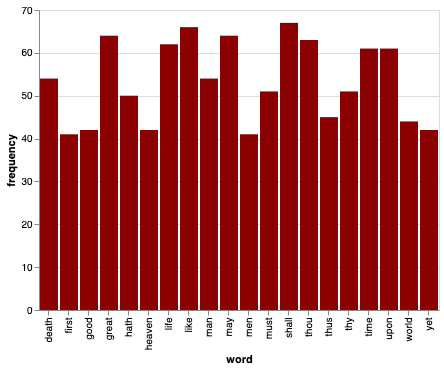

In [31]:
altair_chart(target0)

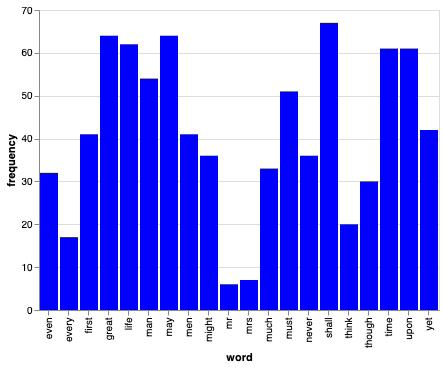

In [32]:
altair_chart(target1, color='blue')

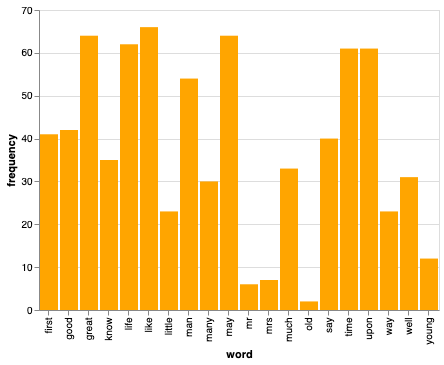

In [33]:
altair_chart(target2, color='orange')

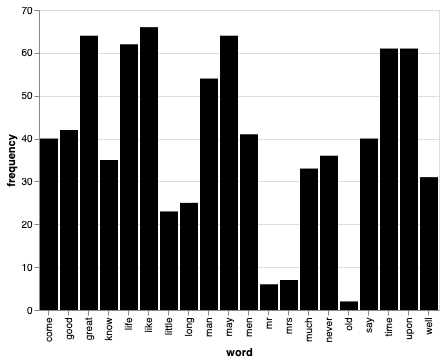

In [34]:
altair_chart(target3, color='black')

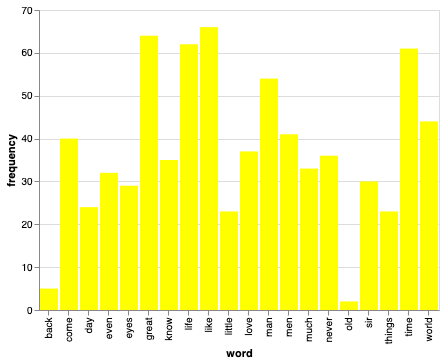

In [35]:
altair_chart(target4, color='yellow')

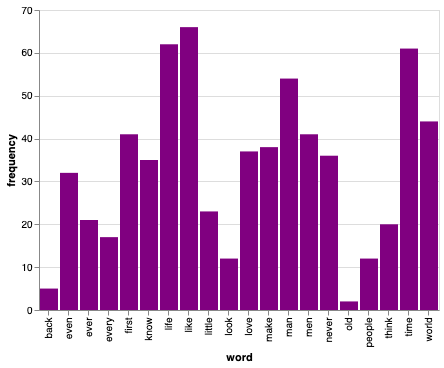

In [36]:
altair_chart(target5, color='purple')

# CountVectorizer for Bigrams

In [37]:
bivec = CountVectorizer(stop_words=stop, ngram_range=(2, 2))
bigrams = pd.DataFrame(bivec.fit_transform(df['text']).todense(), columns=bivec.get_feature_names())
bigrams['target'] = df['target']

In [38]:
target0_bi = bigrams.groupby('target').sum().T.sort_values(by=0, ascending=False)[[0]].head(20)
target1_bi = bigrams.groupby('target').sum().T.sort_values(by=1, ascending=False)[[0]].head(20)
target2_bi = bigrams.groupby('target').sum().T.sort_values(by=2, ascending=False)[[0]].head(20)
target3_bi = bigrams.groupby('target').sum().T.sort_values(by=3, ascending=False)[[0]].head(20)
target4_bi = bigrams.groupby('target').sum().T.sort_values(by=4, ascending=False)[[0]].head(20)
target5_bi = bigrams.groupby('target').sum().T.sort_values(by=5, ascending=False)[[0]].head(20)

In [39]:
target0 = clean_gram_df(target0_bi)
target1 = clean_gram_df(target1_bi)
target2 = clean_gram_df(target2_bi)
target3 = clean_gram_df(target3_bi)
target4 = clean_gram_df(target4_bi)
target5 = clean_gram_df(target5_bi)


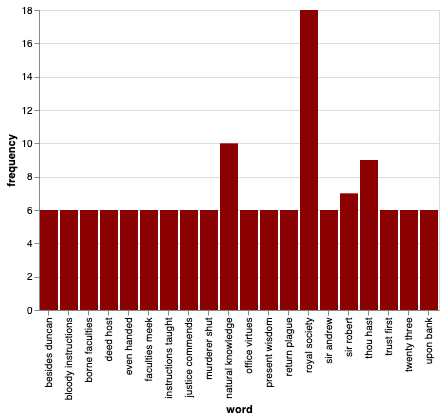

In [40]:
altair_chart(target0)

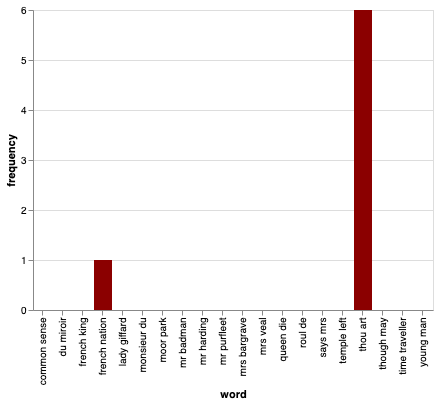

In [41]:
altair_chart(target1)

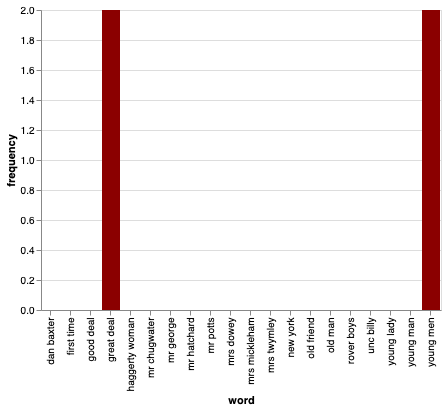

In [42]:
altair_chart(target2)

In [43]:
# Because the dataset is so small, there is not enough data to find bivecs.

# LDA

In [44]:
target0 = df[df.target == 0]['text']
target1 = df[df.target == 1]['text']
target2 = df[df.target == 2]['text']
target3 = df[df.target == 3]['text']
target4 = df[df.target == 4]['text']
target5 = df[df.target == 5]['text']
target6 = df[df.target == 6]['text']

In [45]:
def LDA_graph(target_group):
    
    lda = LDA(n_components=3, random_state=42)
    t = cvec.fit_transform(target_group)
    lda_t = lda.fit_transform(t)
    
    return pyLDAvis.sklearn.prepare(lda, t, cvec)

In [46]:
LDA_graph(target0)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.114228 -0.046267       1        1  48.998170
1     -0.103888 -0.061609       2        1  29.174104
0     -0.010340  0.107876       3        1  21.827726, topic_info=     Category       Freq      Term      Total  loglift  logprob
4041  Default  23.000000      thee  23.000000  30.0000  30.0000
3664  Default  21.000000       sir  21.000000  29.0000  29.0000
1430  Default  17.000000     faith  17.000000  28.0000  28.0000
2538  Default  12.000000      mine  12.000000  27.0000  27.0000
1126  Default  12.000000    divine  12.000000  26.0000  26.0000
1536  Default   8.000000      flat   8.000000  25.0000  25.0000
4203  Default  10.000000    twenty  10.000000  24.0000  24.0000
4493  Default  10.000000    wisdom  10.000000  23.0000  23.0000
1404  Default  22.000000      eyes  22.000000  22.0000  22.0000
711   Default  30.000000      come  30.000000  21.0000  21.0000
1537  Default   7.000000  flatness   7.000000  20.0000  20.0000
3014  Default   9.000000    poetry   9.000000  19.0000  19.0000
549   Default  23.000000    cannot  23.000000  18.0000  18.0000
3579  Default  46.000000     shall  46.000000  17.0000  17.0000
1479  Default   8.000000   feeling   8.000000  16.0000  16.0000
4494  Default  10.000000      wise  10.000000  15.0000  15.0000
1836  Default  10.000000    hardly  10.000000  14.0000  14.0000
1852  Default  40.000000      hath  40.000000  13.0000  13.0000
4464  Default   8.000000   whither   8.000000  12.0000  12.0000
3049  Default  15.000000     power  15.000000  11.0000  11.0000
2625  Default   8.000000    murder   8.000000  10.0000  10.0000
1921  Default  10.000000      hold  10.000000   9.0000   9.0000
1402  Default  12.000000       eye  12.000000   8.0000   8.0000
3179  Default   6.000000   purpose   6.000000   7.0000   7.0000
543   Default  12.000000      call  12.000000   6.0000   6.0000
3536  Default  10.000000     sense  10.000000   5.0000   5.0000
310   Default  18.000000      bear  18.000000   4.0000   4.0000
2760  Default  12.000000     often  12.000000   3.0000   3.0000
950   Default  41.000000     death  41.000000   2.0000   2.0000
1480  Default   7.000000     feels   7.000000   1.0000   1.0000
...       ...        ...       ...        ...      ...      ...
1921   Topic3   6.936745      hold  10.537490   1.1039  -6.1038
1404   Topic3  11.628970      eyes  22.423389   0.8654  -5.5871
2297   Topic3   6.272053      lies   9.954784   1.0600  -6.2045
543    Topic3   6.945779      call  12.262847   0.9535  -6.1025
711    Topic3  12.732725      come  30.367031   0.6528  -5.4965
3579   Topic3  16.192542     shall  46.914294   0.4582  -5.2561
2190   Topic3   8.635434      king  19.549289   0.7049  -5.8848
950    Topic3  13.636123     death  41.573860   0.4072  -5.4279
2659   Topic3   7.286394    nature  15.197927   0.7868  -6.0546
636    Topic3   3.585272     cheek   4.820047   1.2260  -6.7638
622    Topic3   3.576274    charge   4.820871   1.2234  -6.7663
4062   Topic3  14.623219      thou  52.556405   0.2427  -5.3580
1402   Topic3   6.255657       eye  12.501434   0.8296  -6.2071
2305   Topic3  13.642224      like  50.025691   0.2226  -5.4275
2298   Topic3  11.960534      life  49.144195   0.1088  -5.5590
1869   Topic3   9.605196    heaven  32.348247   0.3077  -5.7783
1062   Topic3   5.609708       die  10.572228   0.8883  -6.3161
3738   Topic3   5.585052       son  10.662730   0.8753  -6.3205
2681   Topic3   8.264160     never  25.569615   0.3925  -5.9287
2633   Topic3   9.105691      must  35.649273   0.1572  -5.8317
1725   Topic3   8.273655       god  28.668247   0.2793  -5.9276
4468   Topic3   7.594475     whose  23.875307   0.3766  -6.0132
4533   Topic3   8.470716     world  32.805984   0.1680  -5.9040
4085   Topic3   8.267979      thus  31.448002   0.1860  -5.9282
2466   Topic3   8.967503       may  45.800008  -0.1087  -5.8470
4086   Topic3   8.561490       thy  39.

In [47]:
LDA_graph(target1)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.050765  0.070888       1        1  47.657091
0     -0.046978 -0.072744       2        1  38.795926
1      0.097743  0.001855       3        1  13.546983, topic_info=      Category       Freq         Term       Total  loglift  logprob
5820   Default  90.000000          mrs   90.000000  30.0000  30.0000
2175   Default  27.000000           de   27.000000  29.0000  29.0000
5819   Default  89.000000           mr   89.000000  28.0000  28.0000
10107  Default  73.000000        years   73.000000  27.0000  27.0000
711    Default  17.000000       badman   17.000000  26.0000  26.0000
751    Default  30.000000     bargrave   30.000000  25.0000  25.0000
8827   Default  32.000000        swift   32.000000  24.0000  24.0000
7127   Default  52.000000        queen   52.000000  23.0000  23.0000
9600   Default  28.000000         veal   28.000000  22.0000  22.0000
2216   Default  11.000000  declaration   11.000000  21.0000  21.0000
8530   Default  46.000000        state   46.000000  20.0000  20.0000
7815   Default  32.000000         says   32.000000  19.0000  19.0000
4316   Default  29.000000       honour   29.000000  18.0000  18.0000
3508   Default  97.000000        first   97.000000  17.0000  17.0000
8199   Default  37.000000          sir   37.000000  16.0000  16.0000
9674   Default   9.000000       violet    9.000000  15.0000  15.0000
8997   Default  54.000000    therefore   54.000000  14.0000  14.0000
8938   Default  34.000000       temple   34.000000  13.0000  13.0000
3720   Default  64.000000       french   64.000000  12.0000  12.0000
6744   Default  24.000000       pounds   24.000000  11.0000  11.0000
8581   Default  47.000000        still   47.000000  10.0000  10.0000
9771   Default  46.000000          war   46.000000   9.0000   9.0000
5073   Default  22.000000          law   22.000000   8.0000   8.0000
5151   Default  16.000000       letter   16.000000   7.0000   7.0000
1609   Default   9.000000      colonel    9.000000   6.0000   6.0000
4953   Default  11.000000        kings   11.000000   5.0000   5.0000
7678   Default   8.000000         roul    8.000000   4.0000   4.0000
2187   Default  44.000000        death   44.000000   3.0000   3.0000
321    Default  60.000000         also   60.000000   2.0000   2.0000
1188   Default  19.000000        burke   19.000000   1.0000   1.0000
...        ...        ...          ...         ...      ...      ...
4429    Topic3   5.976093           ii    9.890759   1.4952  -6.8879
5819    Topic3  19.248557           mr   89.154484   0.4661  -5.7182
5151    Topic3   7.907717       letter   16.846945   1.2427  -6.6078
10107   Topic3  16.232098        years   73.972987   0.4823  -5.8887
9402    Topic3   5.889728   understand    9.996806   1.4700  -6.9025
3508    Topic3  16.214548        first   97.887117   0.2011  -5.8898
8530    Topic3  11.619651        state   46.795686   0.6059  -6.2230
5510    Topic3  17.525938          may  146.801527  -0.1264  -5.8120
8997    Topic3  11.408893    therefore   54.024955   0.4440  -6.2413
8581    Topic3  10.628931        still   47.350212   0.5050  -6.3121
4316    Topic3   8.807562       honour   29.523236   0.7894  -6.5001
5073    Topic3   7.908884          law   22.690152   0.9451  -6.6077
2187    Topic3   9.699917        death   44.151509   0.4835  -6.4036
8199    Topic3   9.028064          sir   37.113246   0.5854  -6.4753
3994    Topic3  13.169961        great  131.900276  -0.3051  -6.0977
5955    Topic3  11.923656        never   95.494903  -0.0815  -6.1972
9093    Topic3  12.017625         time  116.197889  -0.2699  -6.1893
5180    Topic3  11.473321         life   99.723176  -0.1634  -6.2357
8180    Topic3   8.762014        since   37.759429   0.5382  -6.5053
9911    Topic3   9.149463        whose   47.878425   0.3440  -6.4620
7812    Topic3  10.019068          say   77.164116  -0.0424  -6.3712
8009    Topic3   8.361496     

In [48]:
LDA_graph(target2)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.043022  0.062741       1        1  40.964508
1     -0.038473 -0.065120       2        1  36.647827
2      0.081495  0.002379       3        1  22.387665, topic_info=      Category        Freq       Term       Total  loglift  logprob
7191   Default  106.000000       love  106.000000  30.0000  30.0000
12128  Default   33.000000       thee   33.000000  29.0000  29.0000
6737   Default   29.000000      kitty   29.000000  28.0000  28.0000
10348  Default  109.000000      rollo  109.000000  27.0000  27.0000
12231  Default   21.000000        thy   21.000000  26.0000  26.0000
7305   Default   27.000000   maitland   27.000000  25.0000  25.0000
10816  Default   17.000000       seth   17.000000  24.0000  24.0000
1480   Default   17.000000      bride   17.000000  23.0000  23.0000
7220   Default   31.000000       lucy   31.000000  22.0000  22.0000
13615  Default   26.000000         ye   26.000000  21.0000  21.0000
11336  Default   42.000000    species   42.000000  20.0000  20.0000
10284  Default   34.000000       ring   34.000000  19.0000  19.0000
2238   Default   17.000000    colonel   17.000000  18.0000  18.0000
2829   Default   13.000000      croft   13.000000  17.0000  17.0000
4441   Default   29.000000       fall   29.000000  16.0000  16.0000
12302  Default   18.000000        tom   18.000000  15.0000  15.0000
907    Default   20.000000      bacon   20.000000  14.0000  14.0000
10845  Default   23.000000     sexual   23.000000  13.0000  13.0000
4988   Default   22.000000  friedrich   22.000000  12.0000  12.0000
13157  Default   22.000000    waldron   22.000000  11.0000  11.0000
1481   Default   39.000000     bridge   39.000000  10.0000  10.0000
7256   Default   11.000000       lyon   11.000000   9.0000   9.0000
3830   Default   20.000000     edmund   20.000000   8.0000   8.0000
7641   Default   67.000000       mind   67.000000   7.0000   7.0000
10851  Default   33.000000     shadow   33.000000   6.0000   6.0000
6787   Default   34.000000     labour   34.000000   5.0000   5.0000
7713   Default   10.000000     mivart   10.000000   4.0000   4.0000
10577  Default  132.000000        say  132.000000   3.0000   3.0000
6598   Default   22.000000    johnson   22.000000   2.0000   2.0000
1773   Default   16.000000    carlyle   16.000000   1.0000   1.0000
...        ...         ...        ...         ...      ...      ...
12183   Topic3   11.827776       thou   18.356101   1.0571  -7.1672
10577   Topic3   40.282842        say  132.286153   0.3076  -5.9417
2265    Topic3   36.076722       come  119.036832   0.3029  -6.0520
7641    Topic3   25.566313       mind   67.169558   0.5307  -6.3964
404     Topic3   26.336993      among   71.466930   0.4984  -6.3667
7871    Topic3   40.836490         mr  155.403177   0.1602  -5.9281
12262   Topic3   49.482128       time  226.101129  -0.0227  -5.7360
7532    Topic3   35.460970        men  135.969748   0.1527  -6.0692
7461    Topic3   39.798608        may  168.099711   0.0559  -5.9538
7618    Topic3   34.699105      might  132.877747   0.1539  -6.0909
13629   Topic3   27.248820        yet   85.818604   0.3494  -6.3326
7366    Topic3   32.169611       many  117.798007   0.1987  -6.1666
5325    Topic3   41.225113       good  190.040372  -0.0315  -5.9186
12852   Topic3   41.124045       upon  191.105806  -0.0396  -5.9211
4478    Topic3   26.509538        far   85.059276   0.3308  -6.3601
7035    Topic3   40.020451       like  202.325932  -0.1238  -5.9483
8755    Topic3   28.523096     people  106.042894   0.1835  -6.2869
13297   Topic3   35.855779       well  174.550658  -0.0861  -6.0581
7914    Topic3   30.521888       must  129.049674   0.0549  -6.2192
7874    Topic3   36.140649       much  191.669885  -0.1717  -6.0502
4178    Topic3   27.437834       even  104.713415   0.1574  -6.3257
8049    Topic3   27.988778      never  120.617381   0.0358  -6.3058
7329    Topic3 

In [51]:
LDA_graph(target3)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.100995  0.016732       1        1  35.174709
1      0.034130 -0.085800       2        1  33.008117
2      0.066864  0.069068       3        1  31.817175, topic_info=      Category        Freq       Term       Total  loglift  logprob
6056   Default  159.000000        mrs  159.000000  30.0000  30.0000
4675   Default   45.000000         im   45.000000  29.0000  29.0000
9736   Default   37.000000        unc   37.000000  28.0000  28.0000
6960   Default   39.000000      poems   39.000000  27.0000  27.0000
884    Default   53.000000       bill   53.000000  26.0000  26.0000
889    Default   39.000000      billy   39.000000  25.0000  25.0000
5076   Default   34.000000      jimmy   34.000000  24.0000  24.0000
4311   Default   33.000000   hatchard   33.000000  23.0000  23.0000
5764   Default   30.000000     meagle   30.000000  22.0000  22.0000
8030   Default   56.000000       says   56.000000  21.0000  21.0000
7852   Default   25.000000    roberts   25.000000  20.0000  20.0000
6788   Default   37.000000      peter   37.000000  19.0000  19.0000
5556   Default   56.000000       love   56.000000  18.0000  18.0000
2720   Default   21.000000      dowey   21.000000  17.0000  17.0000
1218   Default   26.000000      byron   26.000000  16.0000  16.0000
4296   Default   22.000000     harris   22.000000  15.0000  15.0000
9458   Default   20.000000       toad   20.000000  14.0000  14.0000
7037   Default   19.000000     possum   19.000000  13.0000  13.0000
6055   Default  185.000000         mr  185.000000  12.0000  12.0000
2724   Default   21.000000     dowson   21.000000  11.0000  11.0000
9203   Default   21.000000      taine   21.000000  10.0000  10.0000
5854   Default   21.000000     method   21.000000   9.0000   9.0000
7899   Default   18.000000      rover   18.000000   8.0000   8.0000
4559   Default   18.000000  houseboat   18.000000   7.0000   7.0000
203    Default   27.000000         ah   27.000000   6.0000   6.0000
5927   Default   40.000000       miss   40.000000   5.0000   5.0000
9920   Default   18.000000  valentine   18.000000   4.0000   4.0000
5863   Default   17.000000  mickleham   17.000000   3.0000   3.0000
4227   Default   17.000000   haggerty   17.000000   2.0000   2.0000
3638   Default   17.000000         fo   17.000000   1.0000   1.0000
...        ...         ...        ...         ...      ...      ...
8030    Topic3   43.853453       says   56.583975   0.8903  -5.8765
1042    Topic3   20.742465       boys   24.602176   0.9745  -6.6251
8182    Topic3   17.369437       sent   21.328983   0.9398  -6.8026
9741    Topic3   20.731589      uncle   27.873993   0.8491  -6.6257
9352    Topic3   43.981637      think   77.274804   0.5816  -5.8736
5208    Topic3   63.421306       know  130.736308   0.4218  -5.5075
5642    Topic3   15.826006      major   19.669108   0.9278  -6.8957
9263    Topic3   37.722309       tell   65.734002   0.5898  -6.0271
4055    Topic3   42.979212        got   81.447959   0.5059  -5.8966
5657    Topic3   72.602006        man  198.597402   0.1389  -5.3723
9429    Topic3   68.027401       time  188.739943   0.1247  -5.4374
8027    Topic3   43.609019        say   98.778990   0.3275  -5.8821
5475    Topic3   61.490173     little  177.916247   0.0827  -5.5384
4036    Topic3   38.713867      going   82.281011   0.3912  -6.0011
3534    Topic3   31.597995       find   59.186326   0.5176  -6.2042
9371    Topic3   37.786354    thought   85.661821   0.3267  -6.0254
9205    Topic3   33.085520       take   67.578115   0.4310  -6.1582
10314   Topic3   27.624312      woman   48.470118   0.5829  -6.3386
10090   Topic3   30.002606       want   60.092775   0.4506  -6.2560
4042    Topic3   39.034066       good  107.194804   0.1350  -5.9929
5423    Topic3   42.014879       like  126.107458   0.0461  -5.9193
10181   Topic3   39.548861       well  114.517109   0.0820  -5.9798
7814    Topic3 

In [52]:
LDA_graph(target4)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.054565  0.090271       1        1  43.764171
2     -0.116853 -0.003892       2        1  33.906488
0      0.062288 -0.086380       3        1  22.329341, topic_info=     Category       Freq          Term       Total  loglift  logprob
3592  Default  47.000000         jacob   47.000000  30.0000  30.0000
4687  Default  38.000000     panhandle   38.000000  29.0000  29.0000
6385  Default  27.000000    strammfest   27.000000  28.0000  28.0000
441   Default  18.000000            ay   18.000000  27.0000  27.0000
5719  Default  29.000000  schneidekind   29.000000  26.0000  26.0000
324   Default  28.000000           art   28.000000  25.0000  25.0000
1081  Default  17.000000         chris   17.000000  24.0000  24.0000
3054  Default  31.000000        harris   31.000000  23.0000  23.0000
7527  Default  14.000000           wub   14.000000  22.0000  22.0000
3765  Default  14.000000         larry   14.000000  21.0000  21.0000
275   Default  13.000000     appleplex   13.000000  20.0000  20.0000
2792  Default  26.000000        german   26.000000  19.0000  19.0000
5567  Default  11.000000         roman   11.000000  18.0000  18.0000
3849  Default  18.000000        letter   18.000000  17.0000  17.0000
4166  Default  17.000000    metaphysic   17.000000  16.0000  16.0000
6654  Default  19.000000     telephone   19.000000  15.0000  15.0000
6378  Default  21.000000         story   21.000000  14.0000  14.0000
3130  Default  11.000000     hendricks   11.000000  13.0000  13.0000
2051  Default  11.000000       eeldrop   11.000000  12.0000  12.0000
7235  Default  21.000000        vision   21.000000  11.0000  11.0000
7356  Default  38.000000          went   38.000000  10.0000  10.0000
4066  Default  10.000000        marthy   10.000000   9.0000   9.0000
5582  Default  34.000000          rose   34.000000   8.0000   8.0000
827   Default  20.000000     bultiwell   20.000000   7.0000   7.0000
908   Default  11.000000       captain   11.000000   6.0000   6.0000
7145  Default  14.000000           vac   14.000000   5.0000   5.0000
2907  Default  14.000000         grand   14.000000   4.0000   4.0000
7013  Default  17.000000   unconscious   17.000000   3.0000   3.0000
3293  Default   9.000000        icarus    9.000000   2.0000   2.0000
4885  Default  44.000000         place   44.000000   1.0000   1.0000
...       ...        ...           ...         ...      ...      ...
1950   Topic3   9.171559         drink   11.418771   1.2801  -6.6745
3849   Topic3  12.903714        letter   18.526272   1.1376  -6.3331
5570   Topic3   8.426588          rome   10.607753   1.2691  -6.7592
2858   Topic3   9.171587          goes   12.266927   1.2085  -6.6745
7356   Topic3  16.802929          went   38.220755   0.6774  -6.0690
5522   Topic3  17.307549         right   41.959508   0.6137  -6.0394
3872   Topic3  24.353475          like  106.826803   0.0207  -5.6979
4031   Topic3  28.185661           man  145.992176  -0.1455  -5.5518
4136   Topic3  20.902750           men   80.493217   0.1510  -5.8507
449    Topic3  19.112125          back   72.035655   0.1724  -5.9403
1214   Topic3  19.308762          come   80.563620   0.0708  -5.9300
314    Topic3  11.354684        around   24.546402   0.7283  -6.4610
2341   Topic3  15.744694          face   63.234558   0.1089  -6.1341
7353   Topic3  15.044952          well   58.021911   0.1495  -6.1795
2880   Topic3  13.354196           got   42.516461   0.3412  -6.2988
7117   Topic3  17.190608          upon   89.810335  -0.1541  -6.0462
3828   Topic3  12.892495          left   40.987150   0.3427  -6.3339
4048   Topic3  13.343236          many   48.216378   0.2146  -6.2996
6785   Topic3  17.348616          time  117.692684  -0.4153  -6.0371
3906   Topic3  18.081988        little  143.855750  -0.5746  -5.9957
884    Topic3  13.721669          came   54.574156   0.1187  -6.2716
4425   Topic3  14.388158      

In [53]:
LDA_graph(target5)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.021138 -0.092045       1        1  38.693482
1     -0.073816  0.063315       2        1  31.065001
0      0.094954  0.028730       3        1  30.241517, topic_info=     Category       Freq      Term      Total  loglift  logprob
1427  Default  50.000000     every  50.000000  30.0000  30.0000
1574  Default  15.000000       fig  15.000000  29.0000  29.0000
2525  Default  52.000000      love  52.000000  28.0000  28.0000
1963  Default  10.000000     harry  10.000000  27.0000  27.0000
3702  Default   9.000000   science   9.000000  26.0000  26.0000
3289  Default  14.000000    pretty  14.000000  25.0000  25.0000
3772  Default   8.000000       ser   8.000000  24.0000  24.0000
1807  Default  25.000000      girl  25.000000  23.0000  23.0000
1399  Default   7.000000   escaped   7.000000  22.0000  22.0000
1430  Default  12.000000  everyone  12.000000  21.0000  21.0000
3569  Default   9.000000   rhaegar   9.000000  20.0000  20.0000
2503  Default  37.000000      look  37.000000  19.0000  19.0000
1325  Default   7.000000      elma   7.000000  18.0000  18.0000
1024  Default   8.000000  daylight   8.000000  17.0000  17.0000
4763  Default  13.000000   watched  13.000000  16.0000  16.0000
1579  Default   6.000000      figs   6.000000  15.0000  15.0000
4416  Default   7.000000      till   7.000000  14.0000  14.0000
2958  Default  33.000000       old  33.000000  13.0000  13.0000
2488  Default   9.000000     lived   9.000000  12.0000  12.0000
2517  Default  15.000000      lost  15.000000  11.0000  11.0000
4387  Default   8.000000  thousand   8.000000  10.0000  10.0000
255   Default   5.000000    babies   5.000000   9.0000   9.0000
1199  Default  12.000000      done  12.000000   8.0000   8.0000
57    Default   7.000000    afraid   7.000000   7.0000   7.0000
1327  Default   8.000000      else   8.000000   6.0000   6.0000
1264  Default   5.000000    dudley   5.000000   5.0000   5.0000
85    Default   5.000000      alex   5.000000   4.0000   4.0000
1757  Default   8.000000    future   8.000000   3.0000   3.0000
2487  Default  15.000000      live  15.000000   2.0000   2.0000
4920  Default   7.000000        yo   7.000000   1.0000   1.0000
...       ...        ...       ...        ...      ...      ...
2790   Topic3   4.548478        mr   6.458201   0.8454  -6.8021
1420   Topic3  13.835929      even  36.009255   0.2394  -5.6897
2456   Topic3   8.110014     light  15.866651   0.5248  -6.2238
2460   Topic3  19.682129      like  71.488745  -0.0939  -5.3372
2627   Topic3   8.784589       may  18.183100   0.4685  -6.1439
4417   Topic3  15.740800      time  55.448743  -0.0632  -5.5607
3060   Topic3   6.628587      part  11.602373   0.6361  -6.4255
2350   Topic3  13.108740      know  40.992879   0.0558  -5.7437
2860   Topic3  12.347854     never  37.553929   0.0837  -5.8034
3682   Topic3   7.297180       saw  14.479593   0.5107  -6.3294
249    Topic3   9.718173      away  25.766730   0.2209  -6.0429
4004   Topic3   6.688244       son  12.402190   0.5784  -6.4166
3683   Topic3   9.501732       say  25.697087   0.2011  -6.0655
3374   Topic3   6.679459       put  12.402313   0.5771  -6.4179
4803   Topic3   6.669228      went  12.402678   0.5755  -6.4194
1847   Topic3   8.795969     going  26.378662   0.0977  -6.1426
4777   Topic3   8.818695       way  27.116426   0.0727  -6.1401
4376   Topic3   9.216580    things  30.913808  -0.0142  -6.0959
1492   Topic3   8.067273      face  21.313422   0.2244  -6.2291
1881   Topic3   8.111159     great  24.986382   0.0709  -6.2237
4384   Topic3   7.393886    though  18.429050   0.2827  -6.3163
2570   Topic3   8.094310      make  30.862668  -0.1424  -6.2258
4884   Topic3   8.788307     world  49.244613  -0.5274  -6.1435
1858   Topic3   7.387268       got  20.594153   0.1707  -6.3172
3108   Topic3   8.101402    people  35.360539  -0.2776  -6.2249
257    Topic3   8.108494      back  35.

# Sentiment Analysis with Vader

In [54]:
analyzer = SentimentIntensityAnalyzer()

In [55]:
def sentiment_analyzer_scores(sentence):
    score = analyzer.polarity_scores(sentence)
    return score 

In [135]:
df['sentiment'] = df.text.apply(sentiment_analyzer_scores)

In [136]:
df_sent = json_normalize(df.sentiment)

In [110]:
df_sent = df_sent.reset_index()

In [112]:
df_sent = df_sent.drop(columns=['index'])

In [144]:
df = df.join((df_sent), how='outer')

In [60]:
# df.to_csv('../data/cleaned/df_with_sentiment.csv')

In [147]:
df = df.drop(columns=['sentiment'])

In [148]:
compound = df.groupby('target', as_index=False)['compound'].mean()
neg = df.groupby('target', as_index=False)['neg'].mean()
neu = df.groupby('target', as_index=False)['neu'].mean()
pos = df.groupby('target', as_index=False)['pos'].mean()

In [149]:
sentiment_chart = pd.concat([compound, neg, neu, pos], axis=1)

In [150]:
sentiment_chart

,target,compound,target,neg,target,neu,target,pos
0,0,0.201938,0,0.115107,0,0.745550,0,0.139349
1,1,0.515379,1,0.083693,1,0.784344,1,0.131945
2,2,0.627375,2,0.070857,2,0.801138,2,0.128005
3,3,0.497832,3,0.078878,3,0.812527,3,0.108554
4,4,0.273490,4,0.085391,4,0.807667,4,0.106976
5,5,0.109732,5,0.083983,5,0.808239,5,0.107761


In [151]:
sentiment_chart = sentiment_chart.loc[:, ~sentiment_chart.columns.duplicated()]

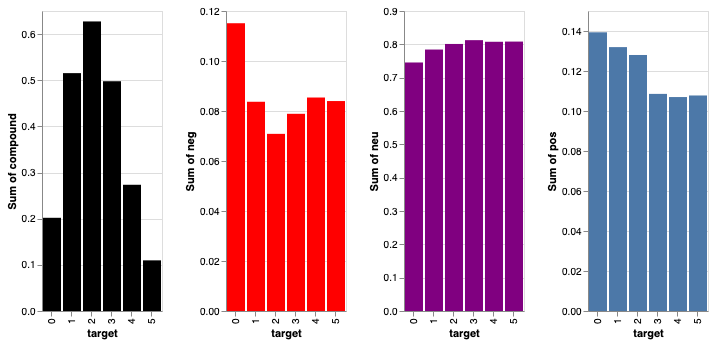

In [152]:
A = alt.Chart(sentiment_chart).mark_bar(color='black').encode(
    x='target:O',
    y='sum(compound):Q'
)

B = alt.Chart(sentiment_chart).mark_bar(color='red').encode(
    x='target:O',
    y='sum(neg):Q'
)

C = alt.Chart(sentiment_chart).mark_bar(color='purple').encode(
    x='target:O',
    y='sum(neu):Q'
)

D = alt.Chart(sentiment_chart).mark_bar().encode(
    x='target:O',
    y='sum(pos):Q'
)

A | B | C | D

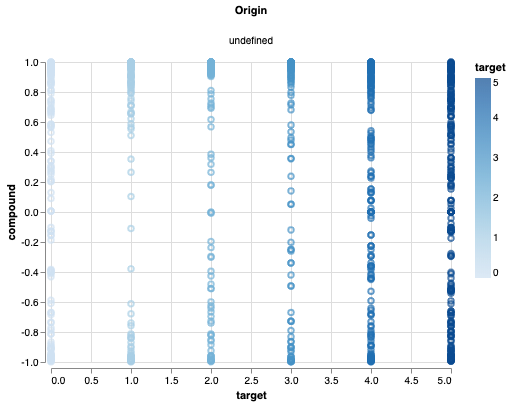

In [153]:
alt.Chart(df).mark_point().encode(
    x='target',
    y='compound',
    color='target',
).facet(column='Origin:N')

In [154]:
df.head()

,date,info,target,text,compound,neg,neu,pos
0,1528,The book of the Courtier,0,then the soul freed from vice purged by studie...,0.9387,0.000,0.800,0.200
1,1569,Hamlet,0,his goodly frame the earth seems to me a steri...,0.9571,0.065,0.719,0.216
2,1592,the spanish tragedy,0,"O eyes, no eyes, but fountains fraught with te...",-0.9577,0.289,0.572,0.138
3,1569,Hamlet,0,firmament this majestical roof fretted with go...,0.3400,0.121,0.737,0.143
4,1623,macbeth,0,mine eyes are made the fools o the other sense...,-0.9794,0.216,0.711,0.073


# Naive Model

In [155]:
X = df['text']
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)


In [156]:
cvec = CountVectorizer(stop_words='english',
                        lowercase=True,
                        ngram_range=(1, 3),
                        strip_accents='unicode')

tvec = TfidfVectorizer(stop_words='english',
                        ngram_range=(1, 3),
                        encoding='utf-8')

In [157]:
X_train_counts = cvec.fit_transform(X_train)
X_test_counts = cvec.transform(X_test)

In [158]:
df_counts = pd.DataFrame(X_train_counts.todense(), columns=cvec.get_feature_names())
df_counts.head()

,101,101 los,101 los altos,138,138 won,138 won couple,451,451 stolid,451 stolid head,650,...,zulu woman,zulu woman wot,zulu wot,zulu wot upset,zurich,zurich staring,zurich staring strangers,zygote,zygote lost,zygote lost land
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [159]:
model = LogisticRegression(solver='lbfgs')
model.fit(X_train_counts, y_train)
print(f'Train score: {model.score(X_train_counts, y_train)}')
print(f'Test score: {model.score(X_test_counts, y_test)}')

Train score: 1.0
Test score: 0.6


In [160]:
y_pred = model.predict(X_test_counts)

In [161]:
def classification_metrics(y_test, y_pred):
    print(f' Accuracy Score: {accuracy_score(y_test, y_pred)}')
    print(f' Precision Score: {precision_score(y_test, y_pred, average = None)}')
    print(f' Recall Score: {recall_score(y_test, y_pred, average = None)}')
    
classification_metrics(y_test, y_pred)

 Accuracy Score: 0.6
 Precision Score: [0.83333333 0.57692308 0.6875     0.72222222 0.58974359 0.48148148]
 Recall Score: [0.60606061 0.51724138 0.5        0.43333333 0.54761905 0.92857143]


In [162]:
confusion_matrix(y_test, y_pred)

array([[20,  0,  0,  0,  1, 12],
       [ 3, 15,  2,  1,  1,  7],
       [ 0,  8, 22,  1,  5,  8],
       [ 0,  3,  6, 13,  6,  2],
       [ 1,  0,  2,  3, 23, 13],
       [ 0,  0,  0,  0,  3, 39]])

In [163]:
predictions = model.predict(X_test_counts)

comparison = pd.DataFrame(predictions, y_test)
comparison = comparison.reset_index()

In [164]:
comparison = comparison.rename(columns={0: 'prediction'})

In [165]:
comparison.head()

,target,prediction
0,0,5
1,3,1
2,0,0
3,4,4
4,3,4


In [166]:
comparison['prediction'] = comparison['prediction'].astype(int)

In [167]:
comparison['correct'] = np.where(comparison['target'] == comparison['prediction'], 1, 0)

In [168]:
comparison = comparison.rename(columns={0: 'prediction'})

In [169]:
comparison.target = comparison.target.astype(int)

In [170]:
comparison.tail()

,target,prediction,correct
215,4,4,1
216,4,4,1
217,2,2,1
218,2,2,1
219,2,2,1


In [171]:
comparison.head()

,target,prediction,correct
0,0,5,0
1,3,1,0
2,0,0,1
3,4,4,1
4,3,4,0


In [172]:
comparison['difference'] = abs(comparison.target - comparison.prediction)

In [173]:
comparison.head()

,target,prediction,correct,difference
0,0,5,0,5
1,3,1,0,2
2,0,0,1,0
3,4,4,1,0
4,3,4,0,1


In [174]:
borderline_dates = len(comparison[comparison['difference'] <= 1]) / len(comparison['difference'])
borderline_dates

0.8045454545454546